In [1]:
import sys
import os 
sys.path.append(os.path.dirname(sys.path[0]) + '/src')
from ast import literal_eval
import pandas as pd

train_df = pd.read_csv('../data/processed/sentipolc/subj_rep_train.csv', converters={'rep': literal_eval})
test_df = pd.read_csv('../data/processed/sentipolc/subj_rep_test.csv', converters={'rep': literal_eval})

In [2]:
from datasets.hyperion_dataset import encode_str_label, LABELS
import numpy as np

def frequency_vec(reps:list) -> list:
    freq = np.zeros(len(LABELS))
    for r in reps:
        freq[encode_str_label(r)] += 1
    return freq

def weigths_vec(reps:list) -> list:
    freq = np.zeros(len(LABELS))
    for r in reps:
        freq[encode_str_label(r)] += 1
        
    return np.divide(freq, len(reps))

In [3]:
X_train = [frequency_vec(reps) for reps in train_df['rep']]
y_train = train_df['iro'].to_list()

X_test = [frequency_vec(reps) for reps in test_df['rep']]
y_test = test_df['iro'].to_list()

In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Irony_Cls(nn.Module):
    def __init__(self):
        super(Irony_Cls, self).__init__()
        self.l1 = nn.Linear(23,64)
        self.l2 = nn.Linear(64,1)
    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        return x

In [117]:
class IronyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __getitem__(self, idx):
        item = {}
        item['input'] = self.X[idx]
        item['labels'] = self.y[idx]
        return item

    def __len__(self):
        return len(self.X)

In [122]:
from torch.utils.data import DataLoader
import time

from utils.utils import format_time

def train(model:nn.Module, loss_fn, optimizer:torch.optim, n_epochs:int, train_dataset):
    total_t0 = time.time()
    # Creation of Pytorch DataLoaders with shuffle=True for the traing phase
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Setup for training with gpu
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    model.to(device)
    loss_fn.to(device)

    for epoch_i in range(0, n_epochs):

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, n_epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode: Dropout layers are active
        model.train()
        
        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            b_input = batch['input'].to(device)
            b_labels = batch['labels'].to(device)
            model.zero_grad()  


            logits = model(b_input)
            loss = loss_fn(logits, b_labels.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()

        # Compute the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.3f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))
    

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



In [181]:
model = Irony_Cls()
train_dataset = IronyDataset(X_train, y_train)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([7.5]))
optimizer = torch.optim.Adam(model.parameters())

train(model, loss_fn, optimizer, 20, train_dataset)


======== Epoch 1 / 20 ========
Training...

  Average training loss: 1.206
  Training epoch took: 0:00:00

======== Epoch 2 / 20 ========
Training...

  Average training loss: 1.195
  Training epoch took: 0:00:00

======== Epoch 3 / 20 ========
Training...

  Average training loss: 1.190
  Training epoch took: 0:00:00

======== Epoch 4 / 20 ========
Training...

  Average training loss: 1.188
  Training epoch took: 0:00:00

======== Epoch 5 / 20 ========
Training...

  Average training loss: 1.186
  Training epoch took: 0:00:00

======== Epoch 6 / 20 ========
Training...

  Average training loss: 1.183
  Training epoch took: 0:00:00

======== Epoch 7 / 20 ========
Training...

  Average training loss: 1.181
  Training epoch took: 0:00:00

======== Epoch 8 / 20 ========
Training...

  Average training loss: 1.180
  Training epoch took: 0:00:00

======== Epoch 9 / 20 ========
Training...

  Average training loss: 1.179
  Training epoch took: 0:00:00

======== Epoch 10 / 20 ========
Trai

2000
Precision iro: 0.198
Precision no iro: 0.914
Recall iro: 0.477
Recall no_iro: 0.742
F1 iro: 0.279
F1 no_iro: 0.819
F1 mean: 0.549
Accuracy: 0.711


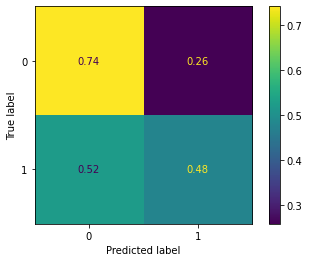

In [182]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

y_pred = torch.sigmoid(model(torch.FloatTensor(X_test)))
y_pred = y_pred.squeeze().tolist()
y_pred = [1 if e > 0.5 else 0 for e in y_pred]
print(len(y_pred))

pr_iro = precision_score(y_test, y_pred, pos_label=1)
pr_no_iro = precision_score(y_test, y_pred, pos_label=0)

rec_iro = recall_score(y_test, y_pred, pos_label=1)
rec_no_iro = recall_score(y_test, y_pred, pos_label=0)

f1_iro = f1_score(y_test, y_pred, pos_label=1)
f1_no_iro = f1_score(y_test, y_pred, pos_label=0)

acc = accuracy_score(y_test, y_pred,)

print('Precision iro: {0:.3f}'.format(pr_iro))
print('Precision no iro: {0:.3f}'.format(pr_no_iro))
print('Recall iro: {0:.3f}'.format(rec_iro))
print('Recall no_iro: {0:.3f}'.format(rec_no_iro))
print('F1 iro: {0:.3f}'.format(f1_iro))
print('F1 no_iro: {0:.3f}'.format(f1_no_iro))
print('F1 mean: {0:.3f}'.format((f1_iro+f1_no_iro)/2))
print('Accuracy: {0:.3f}'.format(acc))

cm = confusion_matrix(y_test, y_pred, labels=[0,1], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=[0,1])
disp.plot()
plt.show()

